# Problemas de Difusión

En el [cuaderno previo](./04_03_EcuacionCalor_2D_Explicita.ipynb) hemos resuelto un problema 2D por primera vez, empleando un esquema explicito. Sabemos que los esquemas explicitos cuentan con restricciones en cuanto a su estabilidad que los tornan impracticos en algunos casos, debido al pequeño tamaño de paso requerido. Por otra parte, los esquemas implicitos son *incondicionalmente estables*, ofreciendo la ventaja de tamaños de paso mas grandes; en el [cuaderno 2](./04_02_EcuacionCalor_1D_Implicita.ipynb) tratamos la solucion implicita 1D del problema de difusion. Para ello, ha sido necesario configurar una matriz de coeficientes y un vector independiente, teniendo en cuenta condiciones de borde, para luego resolver el sistema lineal ... ahora, consideraremos esquemas implicitos en 2D!

## Conduccion de calor 2D

Reescribimos la ecuacion de calor:

$$
\begin{equation}
\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)
\end{equation}
$$

Nuestro planteo previo ha empleado una BC tipo Dirichlet en los bordes izquierdo e inferior, con $T(x=0)=T(y=0)=100$, y una BC tipo Neumann en los bordes superior y derecho, con $q_x=q_y=0$.

$$
\left( \left.\frac{\partial T}{\partial y}\right|_{y=0.1} = q_y \right) \quad \text{and} \quad \left( \left.\frac{\partial T}{\partial x}\right|_{x=0.1} = q_x \right)
$$

La siguiente figura ilustra el diagrama de configuracion del problema:

#### <img src="./figuras/2dchip.svg" width="400px"> 

### Esquemas Implicitos en 2D

Una discretizacion implicita evaluara las derivadas espaciales en el proximo nivel temporal, $t^{n+1}$, usando los valores incognita de la variable solucion. Para la ecuacion de calor 2D con diferencias centradas en espacio, esto se escribe como:

$$
\begin{equation}
    \begin{split}
        & \frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = \\
        & \quad \alpha \left( \frac{T^{n+1}_{i+1, j} - 2T^{n+1}_{i,j} + T^{n+1}_{i-1,j}}{\Delta x^2} + \frac{T^{n+1}_{i, j+1} - 2T^{n+1}_{i,j} + T^{n+1}_{i,j-1}}{\Delta y^2} \right) \\
    \end{split}
\end{equation}
$$

Agrupando aquellos terminos que *desconocemos* del lado izquierdo y aquellos terminos que *conocemos* del lado derecho, obtenemos:

$$
\begin{equation}
    \begin{split}
        & -\frac{\alpha \Delta t}{\Delta x^2} \left( T^{n+1}_{i-1,j} + T^{n+1}_{i+1,j} \right) + \left( 1 + 2 \frac{\alpha \Delta t}{\Delta x^2} + 2 \frac{\alpha \Delta t}{\Delta y^2} \right) T^{n+1}_{i,j} \\
& \quad \quad \quad -\frac{\alpha \Delta t}{\Delta y^2} \left( T^{n+1}_{i,j-1} + T^{n+1}_{i,j+1} \right) = T^n_{i,j} \\
    \end{split}
\end{equation}
$$

Asumamos que el espacio entre nodos de la grilla es el mismo en ambas direcciones, $\Delta x=\Delta y=\delta$:

$$
\begin{equation}
-T^{n+1}_{i-1,j} - T^{n+1}_{i+1,j} + \left(\frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{i,j} - T^{n+1}_{i,j-1}-T^{n+1}_{i,j+1} = \frac{\delta^2}{\alpha \Delta t}T^n_{i,j}
\end{equation}
$$

Asi como en el caso uni-dimensional, $T_{i,j}$ aparece en la ecuacion para $T_{i-1,j}$, $T_{i+1,j}$, $T_{i,j+1}$ y $T_{i,j-1}$, y debemos construir un sistema lineal para avanzar en tiempo. Como armamos la matriz en nuestro caso 2D?

Al emplear esquemas explicitos hemos dispuesto los datos en la matriz 2D `T` de la misma forma en la que se presentan en el problema fisico. Asi, para asignar la temperatura en el nodo proximo en la direccion $x$, hemos codificado $(T_{i+1,j})$ por medio de `T[j,i+1]`, mientras que en la direccion $y$ hemos codificado $(T_{i,j+1})$ por medio de `T[j+1,i]`. Como asignamos los datos al problema fisico en nuestro caso implicito?

Recordemos del [cuaderno de esquemas implicitos 1D](./04_02_EcuacionCalor_1D_Implicita.ipynb) que el sistema lineal tenia $N-2$ elementos. Aplicamos condiciones de borde en los nodos $i=0$ e $i=N-1$, y ellos **no** fueron modificados por el sistema lineal. En nuestro caso 2D, este tratamiento resulta un poco mas complicado.

Observemos la siguiente figura:

#### <img src="./figuras/2D_discretization.png">  Disposicion de los elementos de la matriz en un problema 2D

Consideremos el dominio 2D de tamaño $L_x\times L_y$ discretizado en $n_x$, $n_y$ puntos. Podemos dividir los nodos en *nodos frontera* (circulos vacios) y *nodos interiores* (circulos llenos).

Los nodos frontera son aquellos con indices $(i=0,j)$, $(i=n_x-1,j)$, $(i,j=0)$, $(i,j=n_y-1)$, y las condiciones de borde se imponen en estos.

Los nodos interiores no pertenecen a la frontera, y la ecuacion en diferencias finitas actua sobre estos. Si dejamos los nodos frontera a un lado por el momento, entonces la grilla tendra $(n_x-2)\cdot(n_y-2)$ nodos que necesitan ser actualizados en cada paso de tiempo. Este es el numero de incognitas en el sistema lineal. La matriz de coeficientes tendra $\left( (n_x-2)\cdot(n_y-2) \right)^2$ elementos.

A fin de construir la matriz, iteraremos sobre los nodos en elorden x-principal: esto es, el indice $i$ correra mas rapido. El orden sera:

*  $(i=1,j=1)$
*  $(i=2,j=1)$ ...
*  $(i=nx-2,j=1)$
*  $(i=1,j=2)$
*  $(i=2,j=2)$ ... 
*  $(i=n_x-2,j=n_y-2)$. 

Este es el orden representado por la linea de puntos en la figura anterior. Asi, las ecuaciones para los nodos $(i-1,j)$ e $(i+1,j)$ se ubicaran justo antes y despues de la ecuacion para el nodo $(i,j)$, respectivamente. Mientras que las ecuaciones para los nodos $(i,j-1)$ e $(i,j+1)$ se ubicaran $n_x-2$ posiciones aparte.

### Condiciones Frontera

Consideremos que los bordes izquierdo e inferior estan sujetos a BC tipo Dirichlet, mientras que los bordes superior y derecho estan sujetos a BC tipo Neumann. Tratemos cada caso:

**Borde Inferior:**
    
La ecuacion para $j=1$ (puntos interiores adyacentes al borde inferior) emplea valores de $j=0$, los cuales son conocidos. Ubiquemos a estos del lado derecho de la ecuacion. Tendremos la ecuacion siguiente para todos los puntos a traves del eje $x$ que son adyacentes al borde inferior:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{i-1,1} - T^{n+1}_{i+1,1} + \left( \frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{i,1} - T^{n+1}_{i,2} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{i,1} + T^{n+1}_{i,0} & \\
    \end{split}
\end{equation}
$$

**Borde Izquierdo:**

Asimismo, la ecuacion para $i=1$ (puntos interiores adyacentes al borde izquierdo) emplea valores de $i=0$, y ubicaremos a estos del lado derecho de la ecuacion:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{2,j} + \left( \frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{1,j} - T^{n+1}_{1,j-1} - T^{n+1}_{1,j+1} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{1,j} + T^{n+1}_{0,j} & \\
    \end{split}
\end{equation}
$$

**Borde Derecho:**

La condicion de borde se escribe $\left. \frac{\partial T}{\partial x} \right|_{x=L_x} = q_x$. Su aproximacion en diferencias finitas es:

$$
\begin{equation}
    \frac{T^{n+1}_{n_x-1,j} - T^{n+1}_{n_x-2,j}}{\delta} = q_x
\end{equation}
$$

Escribiendo $T^{n+1}_{n_x-1,j} = \delta q_x + T^{n+1}_{n_x-2,j}$ y reemplazando en la ecuacion general resulta la ecuacion en diferencias finitas para $i=n_x-2$:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{n_x-3,j} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{n_x-2,j} - T^{n+1}_{n_x-2,j-1} - T^{n+1}_{n_x-2,j+1} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{n_x-2,j} + \delta q_x & \\
    \end{split}
\end{equation}
$$

Tome papel y lapiz para verificarlo!

**Borde Superior:**

La BC tipo Neumann especifica la derivada normal a la frontera: $\left. \frac{\partial T}{\partial y} \right|_{y=L_y} = q_y$. En forma analoga al procedimiento seguido para el borde derecho, resulta la siguiente ecuacion para $j=n_y-2$:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{i-1,n_y-2} - T^{n+1}_{i+1,n_y-2} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{i,n_y-2} - T^{n+1}_{i,n_y-3} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{i,n_y-2} + \delta q_y & \\
    \end{split}
\end{equation}
$$

Hasta aqui, tenemos 5 casos posibles: inferior, izquierda, derecha, superior, y puntos interiores. Faltan las *esquinas*!

**Esquina Inferior-Izquierda**

En la ecuacion para $T_{1,1}$ hay BCs tipo Dirichlet en $i=0$ y $j=0$. Esta ecuacion es:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{2,1} + \left( \frac{\delta^2}{\alpha \Delta t} + 4 \right) T^{n+1}_{1,1} - T^{n+1}_{1,2} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{1,1} + T^{n+1}_{0,1} + T^{n+1}_{1,0} & \\
    \end{split}
\end{equation}
$$

**Esquina Superior-Izquierda:**

En la ecuacion para $T_{1,n_y-2}$ hay una BC tipo Dirichlet en $i=0$ y una BC tipo Neumann en $i=n_y-1$. Esta ecuacion es:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{2,n_y-2} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{1,n_y-2} - T^{n+1}_{1,n_y-3} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{1,n_y-2} + T^{n+1}_{0,n_y-2} + \delta q_y & \\
    \end{split}
\end{equation}
$$

**Esquina Superior-Derecha**

En la ecuacion para $T_{n_x-2,n_y-2}$ hay BCs tipo Neumann en $i=n_x-1$ y $j=n_y-1$. Esta ecuacion es:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{n_x-3,n_y-2} + \left( \frac{\delta^2}{\alpha \Delta t} + 2 \right) T^{n+1}_{n_x-2,n_y-2} - T^{n+1}_{n_x-2,n_y-3} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{n_x-2,n_y-2} + \delta(q_x + q_y) & \\
    \end{split}
\end{equation}
$$

**Esquina Inferior-Derecha**

En la ecuacion para $T_{n_x-2,1}$ hay una BC tipo Dirichlet en $j=0$ y una BC tipo Neumann en $i=n_x-1$. Esta ecuacion es:

$$
\begin{equation}
    \begin{split}
        -T^{n+1}_{n_x-3,1} + \left( \frac{\delta^2}{\alpha \Delta t} + 3 \right) T^{n+1}_{n_x-2,1} - T^{n+1}_{n_x-2,2} \qquad & \\
        = \frac{\delta^2}{\alpha \Delta t} T^n_{n_x-2,1} + T^{n+1}_{n_x-2,0} + \delta q_x & \\
    \end{split}
\end{equation}
$$

### El Sistema Lineal

Resolveremos un sistema lineal de ecuaciones en cada paso de tiempo:

$$
[A][T^{n+1}_\text{int}] = [b]+[b]_{b.c.}
$$

La estructura de la matriz de coeficientes puede ser descripta por una serie de bloques diagonales (y ceros afuera). Veamos la siguiente figura y nos referimos a la figura anterior que ilustra la grilla de discretizacion en el espacio fisico.

La primer fila de puntos interiores, adyacentes al borde inferior, genera el bloque $A_1$. La fila superior de puntos interiores, adyacente al borde superior genera el bloque $A_3$. El resto de los puntos interiores en la grilla generan bloques similares $A_2$.

#### <img src="./figuras/implicit-matrix-blocks.png">  Diagrama de bloques en la matriz de coeficientes.

#### <img src="./figuras/matrix-blocks-on-grid.png">  Puntos de la grilla correspondientes a cada bloque.

El bloque $A_1$ es

<img src="./figuras/A_1.svg"  width="640px">

El bloque $A_2$ es

<img src="./figuras/A_2.svg"  width="640px">

El bloque $A_3$ es

<img src="./figuras/A_3.svg"  width="640px">

El vector $T^{n+1}_\text{int}$ contiene la temperatura de los nodos interiores en el proximo paso de tiempo:

$$
\begin{equation}
T^{n+1}_\text{int} = \left[
\begin{array}{c}
T^{n+1}_{1,1}\\
T^{n+1}_{2,1} \\
\vdots \\
T^{n+1}_{n_x-2,1} \\
T^{n+1}_{2,1} \\
\vdots \\
T^{n+1}_{n_x-2,n_y-2}
\end{array}
\right]
\end{equation}
$$

Finalmente, el vector de lado derecho es:

\begin{equation}
[b]+[b]_{b.c.} = 
\left[\begin{array}{c}
\sigma^\prime T^n_{1,1} + T^{n+1}_{0,1} + T^{n+1}_{1,0} \\
\sigma^\prime T^n_{2,0} + T^{n+1}_{2,0} \\
\vdots \\
\sigma^\prime T^n_{n_x-2,1} + T^{n+1}_{n_x-2,0} + \delta q_x \\
\sigma^\prime T^n_{1,2} + T^{n+1}_{0,2} \\
\vdots \\
\sigma^\prime T^n_{n_x-2,n_y-2} + \delta(q_x + q_y)
\end{array}\right]
\end{equation}

donde $\sigma^\prime = 1/\sigma = \delta^2/\alpha \Delta t$. Podria usted responder las siguientes cuestiones:
   * Porque un factor -1 aparece $n_x-2$ columnas despues de la diagonal? Que hay acerca de $n_x-2$ columnas antes de la diagonal?
   * Porque en la fila $n_x-2$ la posicion despues de la diagonal contiene un 0?
   * Porque en la fila $n_x-2$ la diagonal es $\sigma^\prime + 3$ en lugar de $\sigma^\prime + 4$?
   * Porque en la ultima fila la diagonal es $\sigma^\prime + 2$ en lugar de $\sigma^\prime + 4$?

Escribamos ahora una funcion que genere la matriz de coeficientes y el vector de lado derecho para el problema de conduccion de calor planteado en el cuaderno previo. Recordemos que teniamos condiciones tipo Dirichlet en los bordes izquierdo e inferior, y condiciones tipo Neumann con flujo nulo en los bordes superior y derecho $(q_x=q_y=0)$. 

Ademas, importamos `scipy.linalg.solve` puesto que requerimos resolver un sistema lineal.

In [14]:
import numpy
from scipy import linalg

In [15]:
def lhs_operator(M, N, sigma):
    """
    Assembles and returns the implicit operator
    of the system for the 2D diffusion equation.
    We use a Dirichlet condition at the left and
    bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    M : integer
        Number of interior points in the x direction.
    N : integer
        Number of interior points in the y direction.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size M*N by M*N.
    """
    A = numpy.zeros((M * N, M * N))
    for j in range(N):
        for i in range(M):
            I = j * M + i  # row index
            # Get index of south, west, east, and north points.
            south, west, east, north = I - M, I - 1, I + 1, I + M
            # Setup coefficients at corner points.
            if i == 0 and j == 0:  # bottom-left corner
                A[I, I] = 1.0 / sigma + 4.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1 and j == 0:  # bottom-right corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif i == 0 and j == N - 1:  # top-left corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, east] = -1.0
            elif i == M - 1 and j == N - 1:  # top-right corner
                A[I, I] = 1.0 / sigma + 2.0
                A[I, south] = -1.0
                A[I, west] = -1.0
            # Setup coefficients at side points (excluding corners).
            elif i == 0:  # left side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1:  # right side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif j == 0:  # bottom side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif j == N - 1:  # top side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
            # Setup coefficients at interior points.
            else:
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
    return A

In [16]:
def rhs_vector(T, M, N, sigma, Tb):
    """
    Assembles and returns the right-hand side vector
    of the system for the 2D diffusion equation.
    We use a Dirichlet condition at the left and
    bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    M : integer
        Number of interior points in the x direction.
    N : integer
        Number of interior points in the y direction.
    sigma : float
        Value of alpha * dt / dx**2.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side vector as a 1D array of floats
        of size M*N.
    """
    b = 1.0 / sigma * T
    # Add Dirichlet term at points located next
    # to the left and bottom boundaries.
    for j in range(N):
        for i in range(M):
            I = j * M + i
            if i == 0:
                b[I] += Tb
            if j == 0:
                b[I] += Tb
    return b

La solucion del sistema lineal $(T^{n+1}_\text{int})$ contiene la temperatura de los puntos interiores en el proximo paso de tiempo en un vector 1D. Generaremos una funcion que tome los valores de $T^{n+1}_\text{int}$ para disponerlos en un vector 2D el cual se asemeje al dominio fisico.

In [17]:
def map_1d_to_2d(T_1d, nx, ny, Tb):
    """
    Maps a 1D array of the temperature at the interior points
    to a 2D array that includes the boundary values.
    
    Parameters
    ----------
    T_1d : numpy.ndarray
        The temperature at the interior points as a 1D array of floats.
    nx : integer
        Number of points in the x direction of the domain.
    ny : integer
        Number of points in the y direction of the domain.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution in the domain
        as a 2D array of size ny by nx.
    """
    T = numpy.zeros((ny, nx))
    # Get the value at interior points.
    T[1:-1, 1:-1] = T_1d.reshape((ny - 2, nx - 2))
    # Use Dirichlet condition at left and bottom boundaries.
    T[:, 0] = Tb
    T[0, :] = Tb
    # Use Neumann condition at right and top boundaries.
    T[:, -1] = T[:, -2]
    T[-1, :] = T[-2, :]
    return T

Para avanzar en tiempo, utilizaremos:

In [18]:
def btcs_implicit_2d(T0, nt, dt, dx, alpha, Tb):
    """
    Computes and returns the distribution of the
    temperature after a given number of time steps.
    
    The 2D diffusion equation is integrated using
    Euler implicit in time and central differencing
    in space, with a Dirichlet condition at the left
    and bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x and y directions.
    alpha : float
        Thermal diffusivity of the plate.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Get the number of points in each direction.
    ny, nx = T0.shape
    # Get the number of interior points in each direction.
    M, N = nx - 2, ny - 2
    # Compute the constant sigma.
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(M, N, sigma)
    # Integrate in time.
    T = T0[1:-1, 1:-1].flatten()  # interior points as a 1D array
    I, J = int(M / 2), int(N / 2)  # indices of the center
    for n in range(nt):
        # Compute the right-hand side of the system.
        b = rhs_vector(T, M, N, sigma, Tb)
        # Solve the system with scipy.linalg.solve.
        T = linalg.solve(A, b)
        # Check if the center of the domain has reached T = 70C.
        if T[J * M + I] >= 70.0:
            break
    print('[time step {}] Center at T={:.2f} at t={:.2f} s'
          .format(n + 1, T[J * M + I], (n + 1) * dt))
    # Returns the temperature in the domain as a 2D array.
    return map_1d_to_2d(T, nx, ny, Tb)

Recordemos, deseamos que la funcion nos avise cuando el centro de la placa alcance los $70^{\circ}{\rm C}$.

##### Dig deeper

<div class="alert alert-block alert-success">
For demonstration purposes, these functions are very explicit. But you can see a trend here, right? 

Say we start with a matrix with `1/sigma+4` in the main diagonal, and `-1` on the 4 other corresponding diagonals. Now, we have to modify the matrix only where the boundary conditions are affecting. We saw the impact of the Dirichlet and Neumann boundary condition on each position of the matrix, we just need to know in which position to perform those changes. 

A function that maps `i` and `j` into `row_number` would be handy, right? How about `row_number = (j-1)*(nx-2)+(i-1)`? By feeding `i` and `j` to that equation, you know exactly where to operate on the matrix. For example, `i=nx-2, j=2`, which is in row `row_number = 2*nx-5`, is next to a Neumann boundary condition: we have to substract one out of the main diagonal (`A[2*nx-5,2*nx-5]-=1`), and put a zero in the next column (`A[2*nx-5,2*nx-4]=0`). This way, the function can become much simpler!

Can you use this information to construct a more general function `lhs_operator`? Can you make it such that the type of boundary condition is an input to the function? 
</div>

## Difusion de calor 2D

Recuperemos el problema de conduccion de calor 2D tratado en el cuaderno previo, y resolvamos con un esquema implicito. 

In [19]:
# Set parameters.
Lx = 0.01  # length of the plate in the x direction
Ly = 0.01  # length of the plate in the y direction
nx = 21  # number of points in the x direction
ny = 21  # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction
alpha = 1e-4  # thermal diffusivity

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Compute the initial temperature distribution.
Tb = 100.0  # temperature at the left and bottom boundaries
T0 = 20.0 * numpy.ones((ny, nx))
T0[:, 0] = Tb
T0[0, :] = Tb

Listos para correr!

In [20]:
# Set the time-step size based on CFL limit.
sigma = 0.25
dt = sigma * min(dx, dy)**2 / alpha  # time-step size
nt = 300  # number of time steps to compute

# Compute the temperature along the rod.
T = btcs_implicit_2d(T0, nt, dt, dx, alpha, Tb)

[time step 257] Center at T=70.00 at t=0.16 s


Grafiquemos!

In [21]:
from matplotlib import pyplot
%matplotlib inline

In [22]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

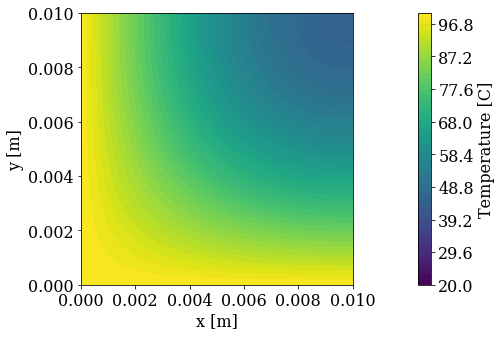

In [23]:
# Plot the filled contour of the temperature.
pyplot.figure(figsize=(8.0, 5.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
levels = numpy.linspace(20.0, 100.0, num=51)
contf = pyplot.contourf(x, y, T, levels=levels)
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]')
pyplot.axis('scaled', adjustable='box');

<div class="alert alert-block alert-info">
    
Try this out with different values of `sigma`! You'll see that it will always give a stable solution!

Does this result match the explicit scheme from the previous notebook? Do they take the same amount of time to reach $70^{\circ}{\rm C}$ in the center of the plate? Now that we can use higher values of `sigma`, we need fewer time steps for the center of the plate to reach $70^{\circ}{\rm C}$! Of course, we need to be careful that `dt` is small enough to resolve the physics correctly.
</div>

---
###### The cell below loads the style of the notebook

In [24]:
from IPython.core.display import HTML
css_file = '.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())